# pyPCGA-TOUGH tutorial example - permeability estimation using pressure and temerature measurements

## Problem description

+ Domiain : 300 m x 100 m x 100 m 
+ 3000 (nx, ny, mz = 30, 30, 10) log-normal permability using Gaussian covariance kernel with scale parameter of [100,100,10] (m) 
+ Boundary conditions: injection-extraction system, warm water injected
+ Simulation time: 374 days
+ Number of unknowns: 3,000 permeabilities (pmx values)
+ Measurements: pressure and temperature collected every 5 days at 128 monitoring locations between the injection and extraction well

In [1]:
%matplotlib inline

- Test environment

In [2]:
import sys
print(sys.version)

3.7.0 (default, Jun 28 2018, 13:15:42) 
[GCC 7.2.0]


In [3]:
import platform
print(platform.platform()) # ubuntu 18.04

Linux-4.15.0-1021-aws-x86_64-with-debian-buster-sid


In [4]:
import numpy as np
print(np.__version__)

1.15.1


In [5]:
import psutil
print('# of physcial CPU cores %s' % (psutil.cpu_count(logical=False)))

# of physcial CPU cores 36


In [6]:
import matplotlib.pyplot as plt
import numpy as np
import tough
from pyPCGA import PCGA
import math
import warnings; warnings.simplefilter('ignore')

- forward model information: model domain, discretization, observation location and interval


In [7]:
# forward model information: model domain, discretization, observation location and interval
nx = [30, 10, 10]
dx = [10., 10., 2.]

# monitoring indices 
xlocs = np.arange(5,21,2)
ylocs = np.array([1,3,5,7])
zlocs = np.array([3,5,7,9])

forward_model_params = {'nx':nx,'dx':dx, 'deletedir':False, 'xlocs': xlocs, 'ylocs':ylocs, 'zlocs':zlocs, \
    'obs_type':['Gas Pressure','Temperature'],'t_obs_interval':86400.*5.,\
    'max_timesteps': 9000, 'tstop': 0.32342126E+08, 'const_timestep': 6, 'max_timestep':86400, \
    'absolute_error': 1, 'relative_error': 5.e-6, 'print_interval': 9000, 'timestep_reduction': 3., \
    'gravity': 9.81,'default_incons': [100.e4, 10], \
    'multi_params':{'num_components': 1, 'num_equations':2, 'num_phases':2, 'num_secondary_parameters':6},
    'solver_params':{'type': 5, 'z_precond':1,'o_precond': 0, 'relative_max_iterations':.8,'closure':1.e-7 },
    'output_times_params': {'num_times_specified':2, 'time': [0.8640E+04, 0.32342126E+08]}}

- true pmx values for comparison purpose

In [8]:
s_true = np.loadtxt("true_30_10_10_gau.txt")

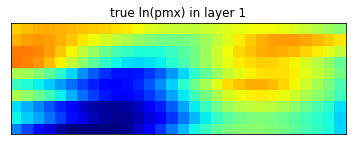

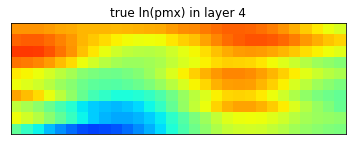

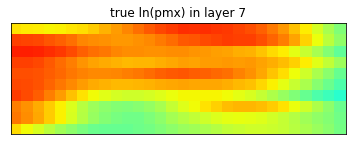

In [9]:
s_true3d = s_true.reshape([nx[2],nx[1],nx[0]])
for i in range(1,10,3):
    plt.figure()
    plt.pcolormesh(s_true3d[i,:,:],vmin=-2.0,vmax=1.5, cmap=plt.get_cmap('jet'))
    plt.title('true ln(pmx) in layer %0d' %(i))
    ax = plt.gca()
    ax.set_aspect('equal', 'box')
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])

- PCGA parameters (m: # of unknowns, N, xmin, xmax: structure grid parameters, prior information)

In [10]:
# dimension of unknown
m = nx[0]*nx[1]*nx[2]
N = np.array([nx[0],nx[1],nx[2]])
xmin = np.array([0.,0.,0.])
xmax = np.array([300.,100.,20.])
pts = None # for regular grids, you don't need to specify pts. 

# covairance kernel and scale parameters
prior_std = 0.7
prior_cov_scale = np.array([100.0,100.0,10.0])

def kernel(r): return (prior_std ** 2) * np.exp(-r**2)

+ load noisy pressure and temperature measurements

measurements were generated as

```python

obs_pres = simul_obs_pres + 10000.*np.random.randn(n_pres,1)  # error std = 1000 Pa for pressure
obs_temp = simul_obs_temp + .5*np.random.randn(n_temp,1)  # error std = 0.5 C for pressure
```

where simul_obs_pres and simul_obs_temp are simulated pressure and temperature at the monitoring ports, respectively

In [11]:
# load noisy observations
obs = np.loadtxt('obs.txt')
nobs = obs.shape[0]

# joint inversion prior error level
std_obs = np.ones_like(obs)
std_obs[:7400]=1000.
std_obs[7400:]=0.5

+ Define a wrapper for a black-box forward model input in pyPCGA

#### 1. Note that one should follow this wrapper format to work with pyPCGA
#### 2. If parallelization == True, it should take multiple columns of s and run the forward problem independently in parallel
#### 3. Please see tough.py as a template for inplementation

In [12]:
# forward model wrapper for pyPCGA
def forward_model(s, parallelization, ncores=None):
    model = tough.Model(forward_model_params)

    if parallelization:
        simul_obs = model.run(s, parallelization, ncores)
    else:
        simul_obs = model.run(s, parallelization)
    return simul_obs

- PCGA inversion parameters

In [13]:
params = {'R': std_obs** 2, 'n_pc': 30,
        'maxiter': 3, 'restol': 0.6,
        'matvec': 'FFT', 'xmin': xmin, 'xmax': xmax, 'N': N,
        'prior_std': prior_std, 'prior_cov_scale': prior_cov_scale,
        'kernel': kernel, 'post_cov': "diag",
        'precond': True, 'LM': True,
        'parallel': True, 'linesearch': True, 'precision': 2e-3,
        'forward_model_verbose': False, 'verbose': False,
        'iter_save': True, 'ncores':6}

# params['objeval'] = False, if true, it will compute accurate objective function

- initial guess

In [14]:
s_init = np.mean(s_true) * np.ones((m, 1))

## Inversion 

- initialize pyPCGA

In [15]:
# initialize
prob = PCGA(forward_model, s_init, pts, params, s_true, obs)

##### PCGA Inversion #####
##### 1. Initialize forward and inversion parameters
------------ Inversion Parameters -------------------------
   Number of unknowns                               : 3000
   Number of observations                           : 14800
   Number of principal components (n_pc)            : 30
   Prior model                                      : def kernel(r): return (prior_std ** 2) * np.exp(-r**2)

   Prior variance                                   : 4.900000e-01
   Prior scale (correlation) parameter              : [100. 100.  10.]
   Posterior cov computation                        : diag
   Posterior variance computation                   : Approx.
   Number of CPU cores (n_core)                     : 6
   Maximum GN iterations                            : 3
   machine precision (delta = sqrt(precision))      : 2.000000e-03
   Tol for iterations (norm(sol_diff)/norm(sol))    : 6.000000e-01
   Levenberg-Marquardt (LM)                         : True
   LM solu

- run pyPCGA

In [16]:
# run inversion
s_hat, simul_obs, post_diagv, iter_best = prob.Run()

##### 2. Construct Prior Covariance Matrix
- time for covariance matrix construction (m = 3000) is 0 sec
##### 3. Eigendecomposition of Prior Covariance
- time for eigendecomposition with k = 30 is 0 sec
- 1st eigv : 369.519, 30-th eigv : 2.52487, ratio: 0.00683285
##### 4. Start PCGA Inversion #####
-- evaluate initial solution
obs. RMSE (norm(obs. diff.)/sqrt(nobs)): 154474, normalized obs. RMSE (norm(obs. diff./sqrtR)/sqrt(nobs)): 154.602
***** Iteration 1 ******
computed Jacobian-Matrix products in 139.933877 secs
solve saddle point (co-kriging) systems with Levenberg-Marquardt
evaluate LM solutions
LM solution evaluted
- Geostat. inversion at iteration 1 is 164 sec
== iteration 1 summary ==
= objective function is 6.382210e+07, relative L2-norm diff btw sol 0 and sol 1 is 24.3275
= L2-norm error (w.r.t truth) is 79.736, obs. RMSE is 92833.5, obs. normalized RMSE is 92.8688
- save results in text at iteration 1
***** Iteration 2 ******
computed Jacobian-Matrix products in 137.22368

In [17]:
post_std = np.sqrt(post_diagv)

s_hat3d = s_hat.reshape([nx[2],nx[1],nx[0]])
post_std = post_std.reshape([nx[2],nx[1],nx[0]])

from mpl_toolkits.axes_grid1 import make_axes_locatable

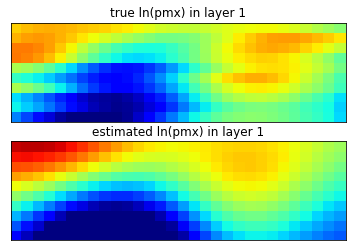

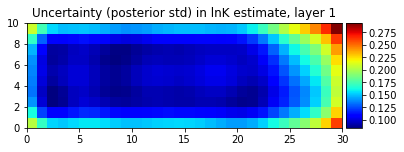

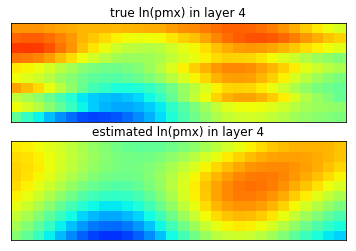

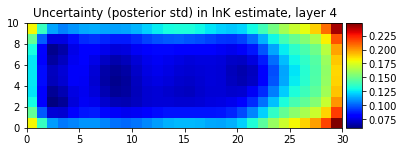

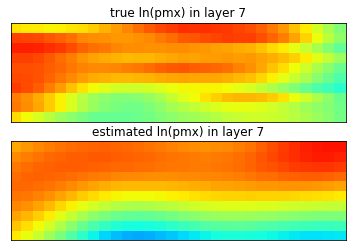

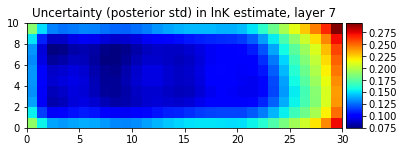

In [18]:
for i in range(1,10,3):
    fig, ax = plt.subplots(nrows=2,ncols=1,sharex=True)
    ax[0].pcolormesh(s_true3d[i,:,:],vmin=-2.0,vmax=1.5, cmap=plt.get_cmap('jet'))
    ax[0].set_title('true ln(pmx) in layer %0d' %(i))
    ax[0].xaxis.set_ticks([])
    ax[0].yaxis.set_ticks([])
    ax[1].pcolormesh(s_hat3d[i,:,:],vmin=-2.0,vmax= 1.5, cmap=plt.get_cmap('jet'))
    ax[1].set_title('estimated ln(pmx) in layer %0d' %(i))
    ax[1].xaxis.set_ticks([])
    ax[1].yaxis.set_ticks([])
    
    fig = plt.figure()
    ax = plt.gca()
    im = plt.pcolor(post_std[i,:,:], cmap=plt.get_cmap('jet'))
    plt.title('Uncertainty (posterior std) in lnK estimate, layer %d' % (i))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    ax.set_aspect('equal', 'box')
    

[None, None]

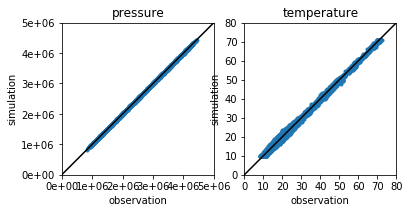

In [19]:
interval_pres = 1000000
interval_temp = 10
nobs = obs.shape[0]
fig, ax = plt.subplots(nrows=1,ncols=2)

obs_pres = obs[:7400]
simul_obs_pres = simul_obs[:7400]
obs_temp = obs[7400:]
simul_obs_temp = simul_obs[7400:]

from matplotlib.ticker import FormatStrFormatter

ax[0].plot(obs_pres,simul_obs_pres,'.')
ax[0].set_xlabel('observation')
ax[0].set_ylabel('simulation')
ax[0].set_title('pressure')
minobs = np.vstack((obs_pres.reshape(-1), simul_obs_pres.reshape(-1))).reshape(-1).min()
maxobs = np.vstack((obs_pres.reshape(-1), simul_obs_pres.reshape(-1))).reshape(-1).max()
xmin, xmax = math.floor(minobs/interval_pres)*interval_pres, math.ceil(maxobs/interval_pres)*interval_pres
ax[0].plot(np.linspace(xmin, xmax, 20), np.linspace(xmin, xmax, 20), 'k-')
ax[0].set_xlim([xmin,xmax])
ax[0].set_ylim([xmin,xmax])
ax[0].xaxis.set_ticks(np.linspace(xmin,xmax,int(xmax/interval_pres)+1))
ax[0].yaxis.set_ticks(np.linspace(xmin,xmax,int(xmax/interval_pres)+1))
ax[0].xaxis.set_major_formatter(FormatStrFormatter('%.0e'))
ax[0].yaxis.set_major_formatter(FormatStrFormatter('%.0e'))
ax[0].set(adjustable='box', aspect='equal')

ax[1].plot(obs_temp,simul_obs_temp,'.')
ax[1].set_xlabel('observation')
ax[1].set_ylabel('simulation')
ax[1].set_title('temperature')
minobs = np.vstack((obs_temp.reshape(-1), simul_obs_temp.reshape(-1))).reshape(-1).min()
maxobs = np.vstack((obs_temp.reshape(-1), simul_obs_temp.reshape(-1))).reshape(-1).max()
xmin, xmax = math.floor(minobs/interval_temp)*interval_temp, math.ceil(maxobs/interval_temp)*interval_temp
ax[1].plot(np.linspace(xmin, xmax, 20), np.linspace(xmin, xmax, 20), 'k-')
ax[1].set_xlim([xmin,xmax])
ax[1].set_ylim([xmin,xmax])
ax[1].xaxis.set_ticks(np.linspace(xmin,xmax,int(xmax/interval_temp)+1))
ax[1].yaxis.set_ticks(np.linspace(xmin,xmax,int(xmax/interval_temp)+1))
ax[1].set(adjustable='box', aspect='equal')


(0.9, 3.1, 316967.16050247126, 82164329.01137531)

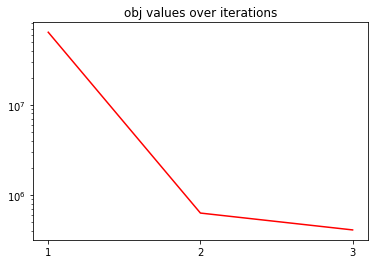

In [20]:
plt.semilogy(np.linspace(1,len(prob.objvals),len(prob.objvals)), prob.objvals, 'r-')
plt.xticks(np.linspace(1,len(prob.objvals),len(prob.objvals)))
plt.title('obj values over iterations')
plt.axis('tight')